In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp_signal


# In simul => noisy => change mfa to mf_analysis
# change the import of wavelet_analysis to wavelet in the noisy script and others locations

### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


In [2]:
gen_path = os.path.abspath(os.path.join(os.getcwd(), '..','03_signal_generation'))
sys.path.append(gen_path)

from signal_gen import generate_synthetic_neural_signal
from decomposition_and_features import extract_mode_features, plot_signal_and_modes, plot_mvmd_grid,run_all_decompositions

In [ ]:
# 1. Pure Oscillations
pure = generate_synthetic_neural_signal(
    add_one_over_f=False,
    add_powerline=False
)

# 2. Oscillations + 1/f Noise
pure_with_noise = generate_synthetic_neural_signal(
    add_one_over_f=True,
    add_powerline=False
)

# 3. MRW Modulated Oscillations (No Noise)
mrw_modulated = generate_synthetic_neural_signal(
    # c1=0.2,
    # c2=-0.15,
    add_one_over_f=False,
    add_powerline=False
)

# 4. MRW + 1/f Noise
mrw_modulated_with_noise = generate_synthetic_neural_signal(
    # c1=0.2,
    # c2=-0.15,
    add_one_over_f=True,
    add_powerline=False
)


In [4]:
def plot_signals(signal_dicts, titles, fs=500, duration=300.0, max_points=None):
    """
    Plots multiple signals for comparison with optional downsampling.

    Parameters:
    - signal_dicts: list of dictionaries containing signal data.
    - titles: list of plot titles.
    - fs: sampling frequency in Hz.
    - duration: duration in seconds to plot.
    - max_points: maximum number of points to display (default None = no limit).
    """
    n_samples_to_plot = int(fs * duration)
    t_full = signal_dicts[0]['time'][:n_samples_to_plot]

    # Determine downsampling step if needed
    step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1

    t = t_full[::step]

    plt.figure(figsize=(15, 10))
    for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
        y_full = signal_dict['final_signal'][:n_samples_to_plot]
        y = y_full[::step]
        plt.subplot(len(signal_dicts), 1, i + 1)
        plt.plot(t, y)
        plt.title(title)
        plt.ylabel("Amplitude")
        if i == len(signal_dicts) - 1:
            plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


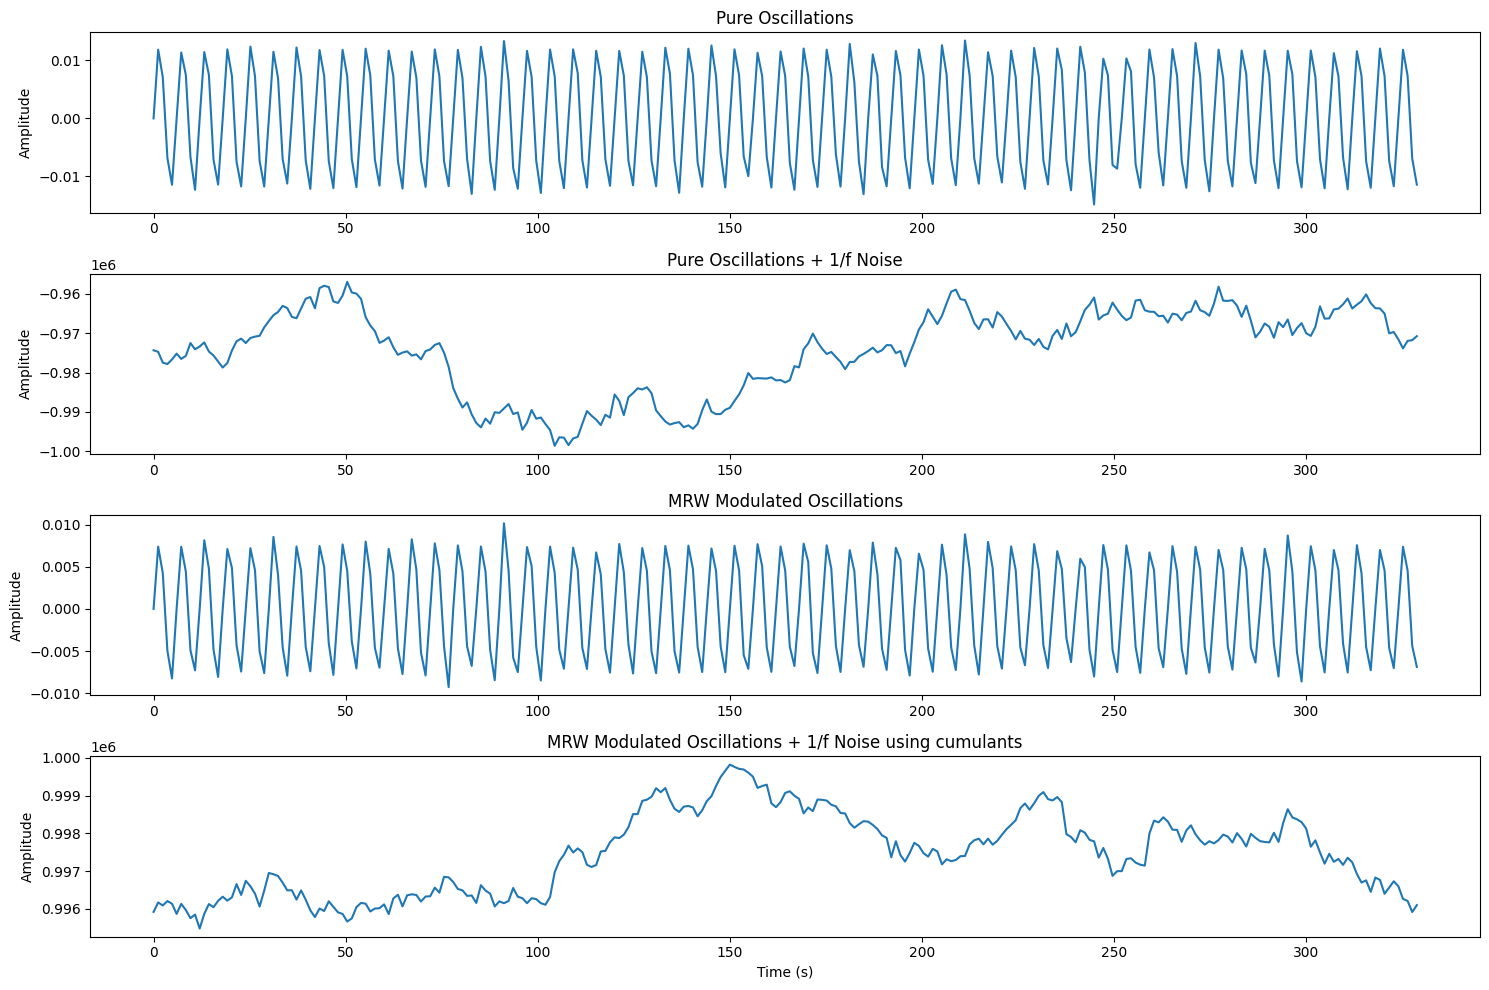

In [5]:
# # Call plotting function with your signals
# plot_signals(
#     [pure, pure_with_noise, mrw_modulated, mrw_modulated_with_noise,mrwH_modulated_with_noise],
#     ["Pure Oscillations",
#      "Pure Oscillations + 1/f Noise",
#      "MRW Modulated Oscillations",
#      "MRW Modulated Oscillations + 1/f Noise using cumulants"],
#      "MRW Modulated Oscillations + 1/f Noise using H"],
#       max_points=500
# )


# Call plotting function with your signals
plot_signals(
    [pure, pure_with_noise, mrw_modulated, mrw_modulated_with_noise],
    ["Pure Oscillations",
     "Pure Oscillations + 1/f Noise",
     "MRW Modulated Oscillations",
     "MRW Modulated Oscillations + 1/f Noise using cumulants"],
     max_points=500
)


In [6]:
def analyze_and_save_signals(
    signals, 
    signal_names, 
    sfreq=250, 
    max_plot_points=None,
    Nmodes=2, 
    methods=None, 
    output_dir='features_output',
    # Optional decomposition parameters
    eemd_trials=100,
    vmd_alpha=200,
    vmd_tau=0,
    vmd_DC=0,
    vmd_init=1,
    vmd_tol=1e-7
):
    """
    Analyze multiple signals with decomposition methods and save the results.

    Optional parameters let you control VMD and EEMD behavior.
    """
    if methods is None:
        methods = ["EMD", "VMD", "VMDtransformer"]

    if signal_names is None or len(signal_names) != len(signals):
        raise ValueError("Please provide signal_names matching the number of signals.")

    os.makedirs(output_dir, exist_ok=True)

    for idx, x in enumerate(signals):
        name = signal_names[idx]
        print(f"\n🚀 Processing: {name}")

        x = x - np.mean(x)
        b, a = sp_signal.butter(4, 40 / (0.5 * sfreq), btype='low')
        x = sp_signal.filtfilt(b, a, x)

        # Forward parameters to run_all_decompositions
        feats_dict, modes_dict = run_all_decompositions(
            x, sfreq, Nmodes, methods=methods, 
            eemd_trials=eemd_trials,
            vmd_alpha=vmd_alpha,
            vmd_tau=vmd_tau,
            vmd_DC=vmd_DC,
            vmd_init=vmd_init,
            vmd_tol=vmd_tol,
            return_modes=True
        )

        for method, features in feats_dict.items():
            method_dir = os.path.join(output_dir, method)
            os.makedirs(os.path.join(method_dir, "metrics"), exist_ok=True)
            os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)
            os.makedirs(os.path.join(method_dir, "figures"), exist_ok=True)

            save_path = os.path.join(method_dir, "metrics", f'{name}.csv')
            if isinstance(features, dict) and 'labels' in features and 'values' in features:
                header = ','.join(features['labels'])
                values = np.array([features['values']])
                np.savetxt(save_path, values, delimiter=',', fmt='%s', header=header, comments='')
            else:
                print(f"⚠️ Skipping {method} on {name} due to missing 'labels' or 'values'.")

            if method in modes_dict:
                modes = modes_dict[method]
                np.save(os.path.join(method_dir, "modes", f'{name}_modes.npy'), modes)
                plot_signal_and_modes(x, sfreq, modes, method, name, output_dir, max_plot_points)


In [7]:
signal_list = [
    pure['final_signal'],
    pure_with_noise['final_signal'],
    mrw_modulated['final_signal'],
    mrw_modulated_with_noise['final_signal'],
    #mrwH_modulated_with_noise['final_signal']
]

signal_names = [
    "pure_oscillations",
    "pure_oscillations_with_noise",
    "mrw_modulated",
    "mrw_modulated_with_noise",
    #"mrwH_modulated_with_noise"
]

In [8]:
# Custom parameters for decomposition methods
analyze_and_save_signals(
    signal_list,
    signal_names,
    sfreq=500,
    Nmodes=4,
    max_plot_points=500 
    #methods=['EMD', 'VMD'],
    #eemd_trials=50,    # Fewer EEMD trials for speed
    #vmd_alpha=500,     # Stronger constraint on bandwidth
    #vmd_tau=1,         # Higher noise tolerance
    #vmd_DC=1,          # DC mode extraction
    #vmd_init=1,        # Initialization strategy
    #vmd_tol=1e-6       # Relaxed convergence tolerance
)



🚀 Processing: pure_oscillations

🚀 Processing: pure_oscillations_with_noise

🚀 Processing: mrw_modulated

🚀 Processing: mrw_modulated_with_noise


In [32]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error

def summarize_decomposition_results_essential(signal_list, signal_names, sfreq, base_dir='features_output', methods_to_check=None,n_modes_to_use=None):
    """
    Lists all extracted modes and adds the number of modes per signal/method.
    """
    if methods_to_check is None:
        methods_to_check = ["EMD", "VMD", "VMDtransformer"]

    records = []

    for method in methods_to_check:
        for signal_name, original_signal in zip(signal_names, signal_list):
            mode_file = os.path.join(base_dir, method, "modes", f"{signal_name}_modes.npy")
            if not os.path.exists(mode_file):
                continue

            modes = np.load(mode_file)
            n_modes_extracted = modes.shape[0]

            mse_full = compute_reconstruction_error(original_signal, modes)
            mse_first4 = compute_reconstruction_error(original_signal, modes, n_modes_to_use=n_modes_to_use)

            for idx, mode in enumerate(modes):
                feats, labels = extract_mode_features(mode, sfreq)
                feat_dict = dict(zip(labels, feats))

                record = {
                    "Method": method,
                    "Signal": signal_name,
                    "Mode Index": idx,
                    "Peak Frequency (Hz)": feat_dict.get("Ppeak", np.nan),
                    #"Band Energy (BM)": feat_dict.get("BM", np.nan),
                    #"Spectral Centroid": feat_dict.get("Cent", np.nan),
                    "Reconstruction MSE (Full)": mse_full,
                    "Reconstruction MSE (First 4 Modes)": mse_first4,
                    "Number of Extracted Modes": n_modes_extracted
                }
                records.append(record)

    df_summary = pd.DataFrame(records)
    return df_summary

In [33]:
from sklearn.metrics import mean_squared_error
import pandas as pd
from IPython.display import display, HTML


def compute_reconstruction_error(original_signal, modes, n_modes_to_use=None):
    """
    Compute the reconstruction error (MSE) between the original signal
    and the sum of the first n_modes_to_use modes (or all modes if None).
    """
    if n_modes_to_use is not None:
        modes_to_sum = modes[:n_modes_to_use]
    else:
        modes_to_sum = modes

    reconstructed = np.sum(modes_to_sum, axis=0)
    # mse = mean_squared_error(original_signal, reconstructed)


    mse = np.mean((original_signal - reconstructed) ** 2)
    var = np.var(original_signal)
    mse = mse / var if var > 0 else np.nan
    return mse




In [34]:
report_df = summarize_decomposition_results_essential(
    signal_list,
    signal_names,
    sfreq=250,
    n_modes_to_use=4
)

#  Show in Notebook
#from IPython.display import display
display(report_df)

#Save to CSV or Excel
report_df.to_csv("decomposition_full_report.csv", index=False)
report_df.to_excel("decomposition_full_report.xlsx", index=False)


,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First 4 Modes),Number of Extracted Modes
0,EMD,pure_oscillations,0,10.000000,0.456935,0.457006,6
1,EMD,pure_oscillations,1,6.000000,0.456935,0.457006,6
2,EMD,pure_oscillations,2,2.000000,0.456935,0.457006,6
3,EMD,pure_oscillations,3,0.863636,0.456935,0.457006,6
4,EMD,pure_oscillations,4,0.393939,0.456935,0.457006,6
...,...,...,...,...,...,...,...
69,VMDtransformer,mrw_modulated_with_noise,3,1.451515,870253.275526,870253.275934,8
70,VMDtransformer,mrw_modulated_with_noise,4,2.975758,870253.275526,870253.275934,8
71,VMDtransformer,mrw_modulated_with_noise,5,7.836364,870253.275526,870253.275934,8
72,VMDtransformer,mrw_modulated_with_noise,6,11.342424,870253.275526,870253.275934,8


In [35]:
df_report = pd.read_csv("decomposition_full_report.csv")

df_report.style.set_table_attributes("style='display:inline'").set_table_styles([
    {'selector': 'table', 'props': [('max-height', '400px'), ('overflow-y', 'scroll'), ('display', 'block')]}
])


,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First 4 Modes),Number of Extracted Modes
0,EMD,pure_oscillations,0,10.000000,0.456935,0.457006,6
1,EMD,pure_oscillations,1,6.000000,0.456935,0.457006,6
2,EMD,pure_oscillations,2,2.000000,0.456935,0.457006,6
3,EMD,pure_oscillations,3,0.863636,0.456935,0.457006,6
4,EMD,pure_oscillations,4,0.393939,0.456935,0.457006,6
5,EMD,pure_oscillations,5,0.078788,0.456935,0.457006,6
6,EMD,pure_oscillations_with_noise,0,8.727273,8524.594941,8525.576641,9
7,EMD,pure_oscillations_with_noise,1,3.612121,8524.594941,8525.576641,9
8,EMD,pure_oscillations_with_noise,2,1.724242,8524.594941,8525.576641,9
9,EMD,pure_oscillations_with_noise,3,0.933333,8524.594941,8525.576641,9
